# Making maps with Python 

In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gp
import pyproj


## Method 1: Folium (based upon Leaflet.js)

First we'll start with [Folium](http://python-visualization.github.io/folium/), which use [Leaflet](http://leafletjs.com/), which is excellent for simple interactive maps and showcasing data. 

In [2]:
import folium
m=folium.Map(
    location=[36.5236, -87.6750],
    tiles='Stamen Toner',
    zoom_start=4
)
m


Now let's change the basemap and add some vector layers 

In [3]:
m=folium.Map(
    location=[36.5236, -87.6750],
    tiles='Mapbox Bright',
    zoom_start=4
)
folium.Marker([45.3288, -100.6625], popup='<i>I"m a marker!</i>').add_to(m)
folium.CircleMarker(
    location=[37.5215, -112.6261],
    radius=50,
    popup='I"m a circle',
    color='#3186cc',
    fill=True,
    fill_color='#3186cc'
).add_to(m)
m

<h1>Using Geopandas</h1>

While Folium looks nice, I tend to prefer using Geopandas. Being built upon Pandas means it's lighting fast and the syntax is similar to Pandas. So you can easily manipulate fields and process data quickly. 

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gp
usa=gp.read_file('united-states/us-albers-counties.json')
plt.style.use('fivethirtyeight')

It's really easy to plot data using Geopandas. 

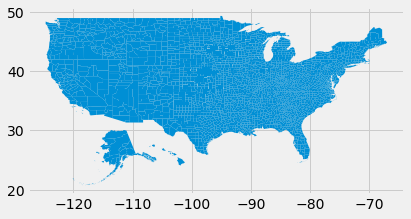

In [5]:
usa.plot()

Okay so we may need to clean this up some. Like doing away with the pesky axis, enlarging the map and creating a choropleth map. 

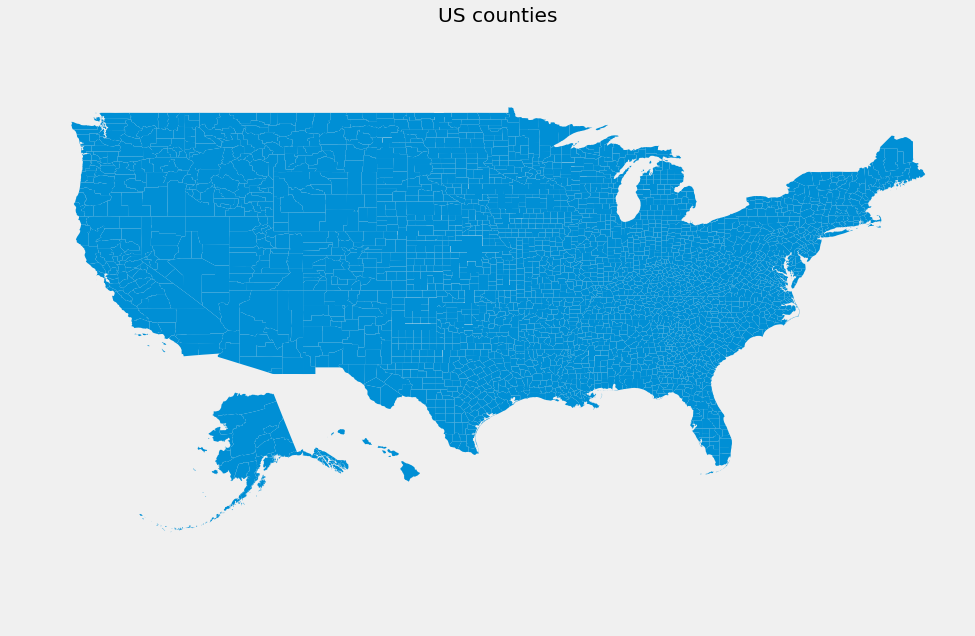

In [6]:
f, ax = plt.subplots(1, figsize=(15, 10))
ax.set_title("US counties")
ax.set_axis_off()
plt.axis('equal');
usa.plot(ax=ax)
plt.show()

Before proceeding let's take a quick look at our data. 

In [7]:
usa.head()

id   fips state_fips county_fips      name    lsad  census_area    state  \
0  0  01001         01         001   Autauga  County      594.436  Alabama   
1  1  01009         01         009    Blount  County      644.776  Alabama   
2  2  01017         01         017  Chambers  County      596.531  Alabama   
3  3  01021         01         021   Chilton  County      692.854  Alabama   
4  4  01033         01         033   Colbert  County      592.619  Alabama   

  iso_3166_2                                           geometry  
0         AL  POLYGON ((-86.49415438373838 32.34371720414687...  
1         AL  POLYGON ((-86.57505906480648 33.76424986583291...  
2         AL  POLYGON ((-85.18234276927693 32.86994691485243...  
3         AL  POLYGON ((-86.51727000690069 33.01947666871411...  
4         AL  POLYGON ((-88.14114253405342 34.5809123676929,...

In [8]:
unemployment=pd.read_csv('unemployment.csv')
unemployment.head()

FIPStxt State           Area_name  Rural_urban_continuum_code_2013  \
0     1000    AL             Alabama                              NaN   
1     1001    AL  Autauga County, AL                              2.0   
2     1003    AL  Baldwin County, AL                              3.0   
3     1005    AL  Barbour County, AL                              6.0   
4     1007    AL     Bibb County, AL                              1.0   

   Urban_influence_code_2013  Metro_2013 Civilian_labor_force_2007  \
0                        NaN         NaN                 2,175,612   
1                        2.0         1.0                    24,383   
2                        2.0         1.0                    82,659   
3                        6.0         0.0                    10,334   
4                        1.0         1.0                     8,791   

  Employed_2007 Unemployed_2007  Unemployment_rate_2007  \
0     2,089,127          86,485                     4.0   
1        23,577             806                     3.3   
2        80,099           2,560                     3.1   
3         9,684             650                     6.3   
4         8,432             359                     4.1   

                     ...                    Civilian_labor_force_2015  \
0                    ...                                    2,152,289   
1                    ...                                       25,303   
2                    ...                                       87,756   
3                    ...                                        8,646   
4                    ...                                        8,526   

  Employed_2015 Unemployed_2015  Unemployment_rate_2015  \
0     2,020,675         131,614                     6.1   
1        23,971           1,332                     5.3   
2        82,882           4,874                     5.6   
3         7,881             765                     8.8   
4         7,957             569                     6.7   

  Civilian_labor_force_2016 Employed_2016 Unemployed_2016  \
0                 2,168,608     2,038,775         129,833   
1                    25,649        24,297           1,352   
2                    89,931        85,061           4,870   
3                     8,302         7,584             718   
4                     8,573         8,004             569   

   Unemployment_rate_2016 Median_Household_Income_2015  \
0                     6.0                       44,833   
1                     5.3                       56,580   
2                     5.4                       52,387   
3                     8.6                       31,433   
4                     6.6                       40,767   

  Med_HH_Income_Percent_of_State_Total_2015  
0                                     100.0  
1                                     126.2  
2                                     116.8  
3                                      70.1  
4                                      90.9  

[5 rows x 48 columns]

Now I'm going to merge our two datasets together to create a choropleth map. 

In [9]:
usa['FIPStxt']=pd.to_numeric(usa['fips'].str[1:])
#=pd.merge(unemployment, usa, how='right', on='FIPStxt')
US_jobs = usa.merge(unemployment, on='FIPStxt')

Let's go ahead and plot everything to make sure the merge was successful. 

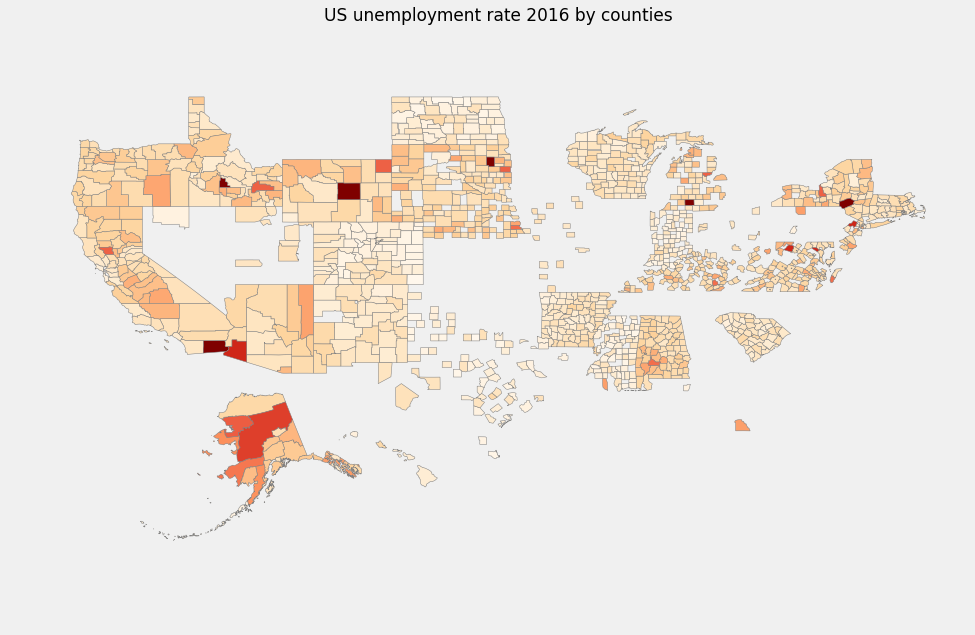

In [10]:
f, ax = plt.subplots(1, figsize=(15, 10))
ax.set_title("US unemployment rate 2016 by counties" , fontsize=17)
ax.set_axis_off()
plt.axis('equal')
US_jobs.plot( column='Unemployment_rate_2016' ,cmap='OrRd', ax=ax,  edgecolor='grey')
plt.show()

So it turns out that not everything made it through the merge. So let's pick a state that made it through the merge, focus on that and do some number crunching. I'm going to go with California.

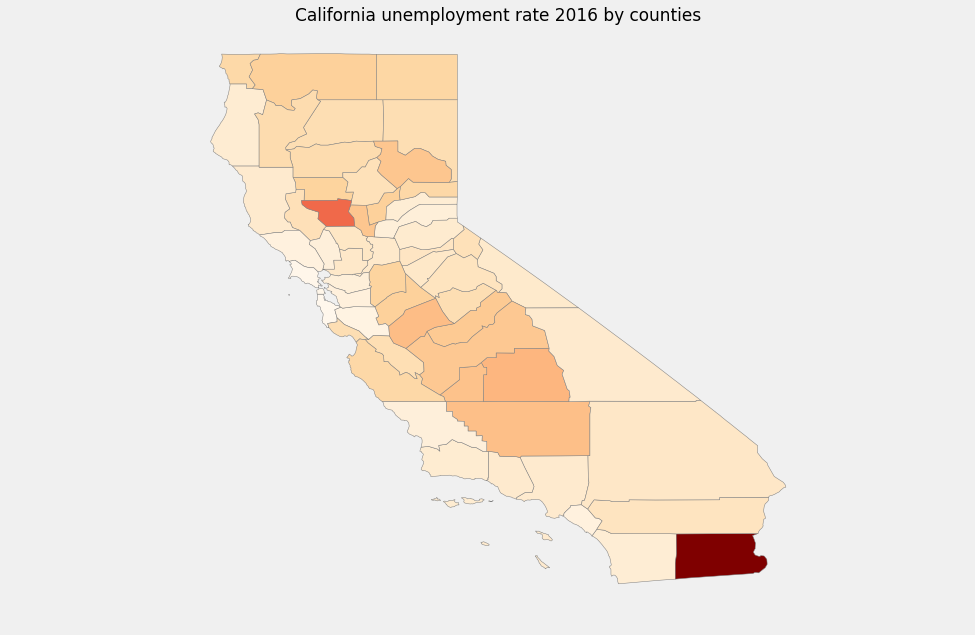

In [12]:
CA_jobs=US_jobs.loc[US_jobs['iso_3166_2'] == 'CA'] 
f, ax = plt.subplots(1, figsize=(15, 10))
ax.set_title("California unemployment rate 2016 by counties", fontsize=17)
ax.set_axis_off()
plt.axis('equal')
CA_jobs.plot( column='Unemployment_rate_2016' ,cmap='OrRd', ax=ax,  edgecolor='grey')
plt.show()

Great! Let's dig a little further and do some graphing with Matplotlib. First I'm going to list all the columns so we know which column headers to pick. 

In [13]:
list(CA_jobs.columns.values)

['id',
 'fips',
 'state_fips',
 'county_fips',
 'name',
 'lsad',
 'census_area',
 'state',
 'iso_3166_2',
 'geometry',
 'FIPStxt',
 'State',
 'Area_name',
 'Rural_urban_continuum_code_2013',
 'Urban_influence_code_2013',
 'Metro_2013',
 'Civilian_labor_force_2007',
 'Employed_2007',
 'Unemployed_2007',
 'Unemployment_rate_2007',
 'Civilian_labor_force_2008',
 'Employed_2008',
 'Unemployed_2008',
 'Unemployment_rate_2008',
 'Civilian_labor_force_2009',
 'Employed_2009',
 'Unemployed_2009',
 'Unemployment_rate_2009',
 'Civilian_labor_force_2010',
 'Employed_2010',
 'Unemployed_2010',
 'Unemployment_rate_2010',
 'Civilian_labor_force_2011',
 'Employed_2011',
 'Unemployed_2011',
 'Unemployment_rate_2011',
 'Civilian_labor_force_2012',
 'Employed_2012',
 'Unemployed_2012',
 'Unemployment_rate_2012',
 'Civilian_labor_force_2013',
 'Employed_2013',
 'Unemployed_2013',
 'Unemployment_rate_2013',
 'Civilian_labor_force_2014',
 'Employed_2014',
 'Unemployed_2014',
 'Unemployment_rate_2014',
 'Ci

Now I'm going to make a time series plot for all unemployment rates from 2007 to 2016 for all the California counties. Given that there are 58 of them I'll forgo adding county labels.

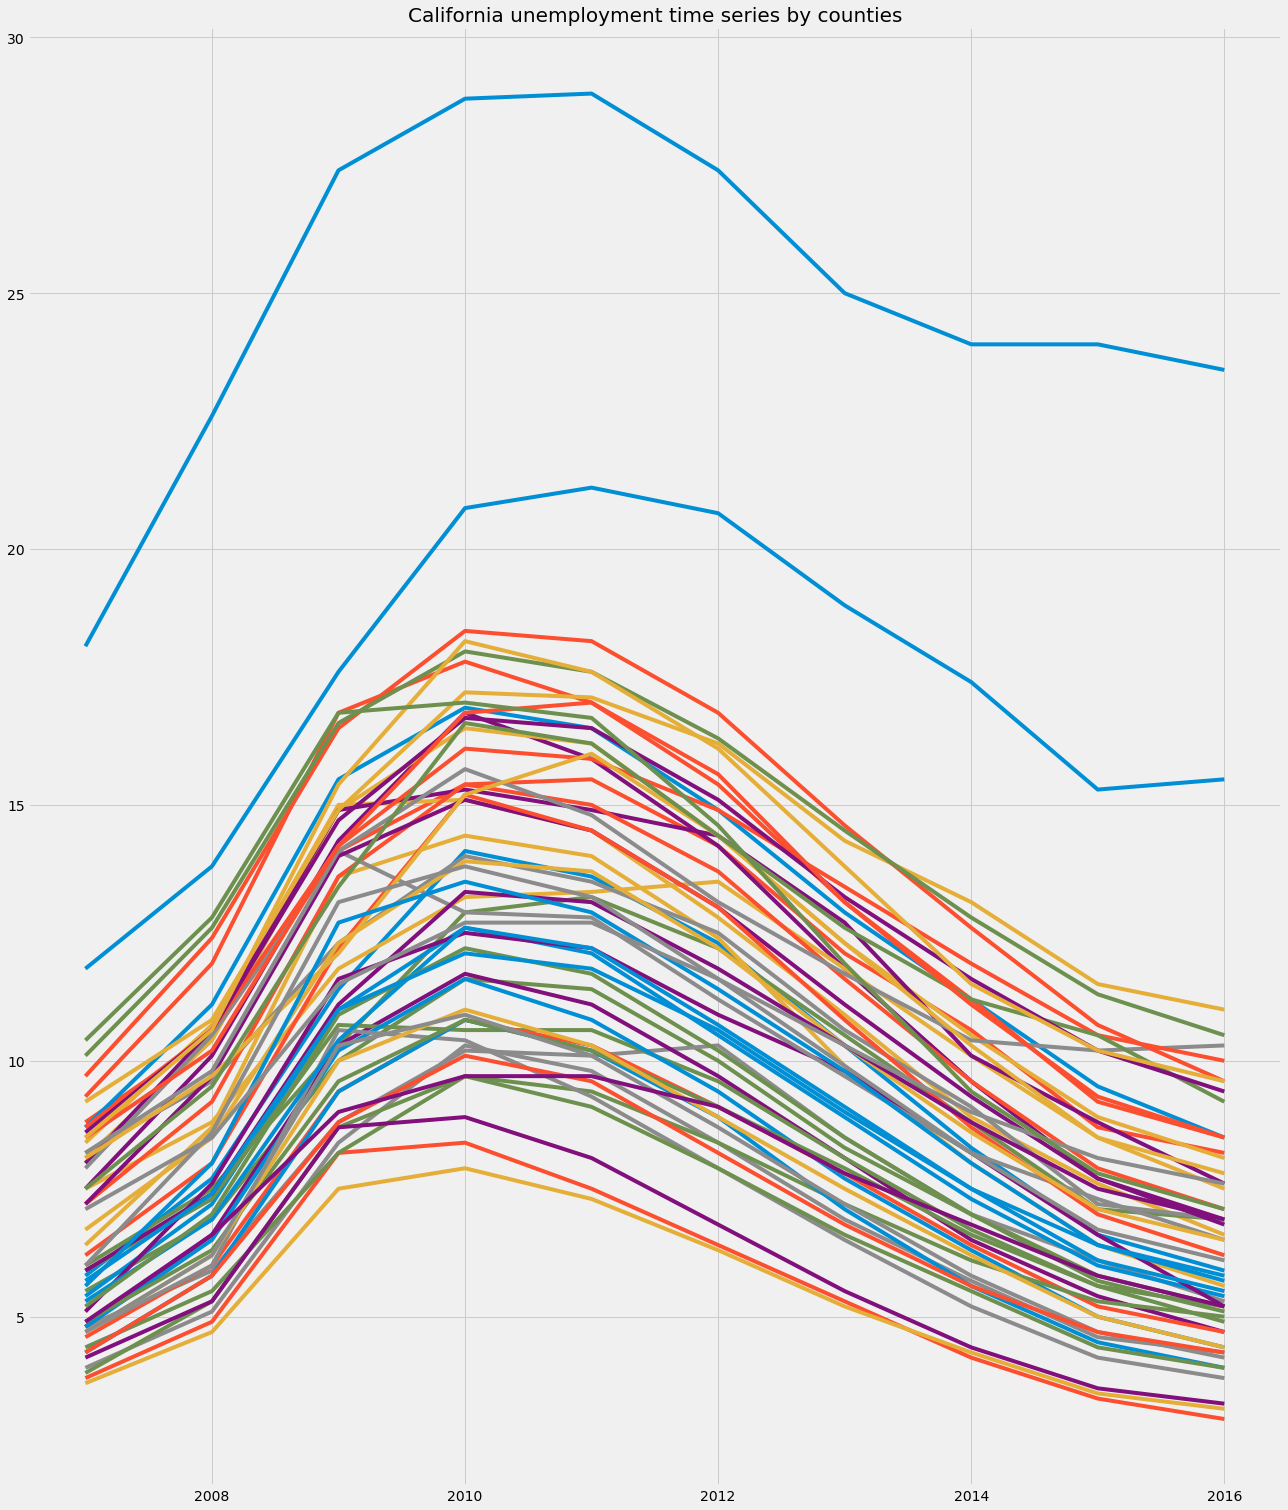

In [14]:
f, ax = plt.subplots(1, figsize=(20, 25))
ax.set_title("California unemployment time series by counties", fontsize=20)
CA_jobs2 = CA_jobs.filter(regex='Unemployment_rate')
plt.plot(pd.Series(list(range(2007,2017))), CA_jobs2.T)
plt.show()

Well, this is for now the end of my first blog post. I might come back add some more map making methods later on, but for now the plan is to keep updating things and add more posts. I hope the material here has been informative. Please feel free to contact me about any potential improvements. Thank you free reading my blog, now go make some awesome maps! 